In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

# Define a transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('path/to/save/data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the validation data
valset = datasets.MNIST('path/to/save/data', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

100.0%


Extracting path/to/save/data/MNIST/raw/train-images-idx3-ubyte.gz to path/to/save/data/MNIST/raw



100.0%

Extracting path/to/save/data/MNIST/raw/train-labels-idx1-ubyte.gz to path/to/save/data/MNIST/raw




100.0%
100.0%


Extracting path/to/save/data/MNIST/raw/t10k-images-idx3-ubyte.gz to path/to/save/data/MNIST/raw

Extracting path/to/save/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to path/to/save/data/MNIST/raw



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#Set layer sizes (MNIST picture = 28x28) (Output is 10 classes for digits 0-9)
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
output_size = 10

#Define ReLU and its derivative activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

#Using softmax function for output layer
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

#Loss function
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

#Define NN (3-Layer)
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.w1 = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
        self.b1 = np.zeros(hidden_size1)
        self.w2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
        self.b2 = np.zeros(hidden_size2)
        self.w3 = np.random.randn(hidden_size2, output_size) / np.sqrt(hidden_size2)
        self.b3 = np.zeros(output_size)

    #Forward Pass
    def forward(self, x):
        self.z1 = x.dot(self.w1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1.dot(self.w2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = self.a2.dot(self.w3) + self.b3
        self.output = softmax(self.z3)
        return self.output

    #Backward Pass
    def backward(self, x, y):
        m = y.shape[0]
        dz3 = self.output - y
        dw3 = self.a2.T.dot(dz3) / m
        db3 = dz3.mean(axis=0)

        dz2 = dz3.dot(self.w3.T) * relu_derivative(self.z2)
        dw2 = self.a1.T.dot(dz2) / m
        db2 = dz2.mean(axis=0)

        dz1 = dz2.dot(self.w2.T) * relu_derivative(self.z1)
        dw1 = x.T.dot(dz1) / m
        db1 = dz1.mean(axis=0)

        return [dw1, db1, dw2, db2, dw3, db3]

def test_momentum(network, gradients, learning_rate, momentum, momentums):
    #Get weights and biases from gradient
    dw1, db1, dw2, db2, dw3, db3 = gradients

    #Update weights with momentum
    momentums[0] *= momentum
    momentums[0] += learning_rate * dw1
    network.w1 -= momentums[0]

    momentums[2] *= momentum
    momentums[2] += learning_rate * dw2
    network.w2 -= momentums[2]

    momentums[4] *= momentum
    momentums[4] += learning_rate * dw3
    network.w3 -= momentums[4]

    #Update biases with momentum
    momentums[1] *= momentum
    momentums[1] += learning_rate * db1
    network.b1 -= momentums[1]

    momentums[3] *= momentum
    momentums[3] += learning_rate * db2
    network.b2 -= momentums[3]

    momentums[5] *= momentum
    momentums[5] += learning_rate * db3
    network.b3 -= momentums[5]

#Set learning rate, momentum rate, epochs, and initialize loss list
learning_rate = 0.001
momentum_rate = 0.9
epochs = 50
losses = []

#Initialize NN and momentum
nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
momentums = [np.zeros_like(param) for param in [nn.w1, nn.b1, nn.w2, nn.b2, nn.w3, nn.b3]]

#Train
for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        #Convert PyTorch tensors to NumPy
        images_np = images.numpy().reshape(images.size(0), -1)
        labels_np = labels.numpy()

        #One-hot encode labels
        labels_one_hot = np.zeros((labels_np.size, 10))
        labels_one_hot[np.arange(labels_np.size), labels_np] = 1

        #Forward pass
        output = nn.forward(images_np)

        #Backward pass
        gradients = nn.backward(images_np, labels_one_hot)
        test_momentum(nn, gradients, learning_rate, momentum_rate, momentums)

        loss = mse_loss(labels_one_hot, output)
        epoch_loss += loss

    epoch_loss /= len(trainloader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss}")



Epoch 1/50, Loss: 0.03046534444155647
Epoch 2/50, Loss: 0.014715054693944036
Epoch 3/50, Loss: 0.01262084598246669
Epoch 4/50, Loss: 0.011187024584236108
Epoch 5/50, Loss: 0.010095710839282606
Epoch 6/50, Loss: 0.009116691705357569
Epoch 7/50, Loss: 0.008266584624916112
Epoch 8/50, Loss: 0.007586521206019334
Epoch 9/50, Loss: 0.007031729477843097
Epoch 10/50, Loss: 0.006503359748036725
Epoch 11/50, Loss: 0.006085807696128007
Epoch 12/50, Loss: 0.005687817004661526
Epoch 13/50, Loss: 0.005391789692632648
Epoch 14/50, Loss: 0.005124900597730706
Epoch 15/50, Loss: 0.004845021482689681
Epoch 16/50, Loss: 0.004622610957423055
Epoch 17/50, Loss: 0.004381205834707977
Epoch 18/50, Loss: 0.00419892041000132
Epoch 19/50, Loss: 0.0040003967697839005
Epoch 20/50, Loss: 0.003834819675463346
Epoch 21/50, Loss: 0.0037042767750542255
Epoch 22/50, Loss: 0.0035290449279952534
Epoch 23/50, Loss: 0.0033927475716650918
Epoch 24/50, Loss: 0.003257266564782183
Epoch 25/50, Loss: 0.0031453637384501122
Epoch 2

In [19]:
def predict_label(nn, image):
    output = nn.forward(image)
    return np.argmax(output, axis=1)

correct_count, all_count = 0, 0
for images, labels in valloader:
    # Flatten and normalize the images, and convert to NumPy
    images_np = images.numpy().reshape(images.size(0), -1)

    # Predict labels using the neural network instance
    predicted_labels = predict_label(nn, images_np)

    # Convert PyTorch tensor to NumPy array for true labels
    true_labels = labels.numpy()

    # Compare predicted labels with true labels
    correct_count += np.sum(predicted_labels == true_labels)
    all_count += labels.size(0)

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count / all_count))



Number Of Images Tested = 10000

Model Accuracy = 0.9755


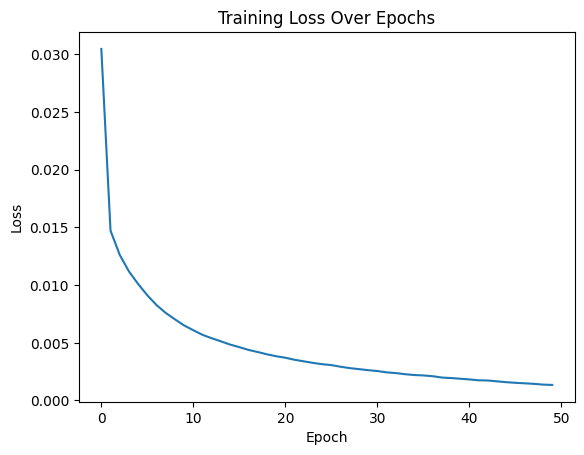

In [20]:
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()